# How bad is the 4th wave going to be in Germany?

We explore two scenarios for the next month:

- Option 1: The R-value stays at 1.25 (as it has been for a few days now). This is exponential growth.

- Option 2: We see a linear increase in the *daily* new infections for the past week: we assume this trend continues - this is quadratic growth in the total number of infections. (This would reflect an R value that decreases over time.) 

  This assumption is based on the good fit (see relevant plot below), and the experience that a similar fit was a fairly good prediction in the early stages of the outbreak in China. There is no other good reason for investigating this assumption.


Outline of document:

- we compute the daily new infections as an average over the last week (to get rid of reporting fluctuations)

- we define some convenience functions

- we show data for Option 1 and Option 2

- we close with a discussion

In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import oscovida as ov
%config InlineBackend.figure_formats = ['svg']
# ov.clear_cache()

In [2]:
cases_jh, deaths_jh = ov.get_country_data("Germany")

# compute weekly mean (average over the last 7 days) - 
# this is proportional to the incidence
c = cases_jh.rolling(window=7, center=False).mean()

# infections per day (averaged over 7 days), for the last 42 days only
daily_cases = c.diff()[-42:]

In [3]:
# We define one more conveniene function to plot our 
# results (please ignor the code)

def daily_growth_to_incidence(g, country='Germany'):
    """Given a time series g of new infections per day, 
    return the corresponding incidence (for country)"""
    pop = ov.population(country)
    
    # 7 days * g new cases
    new_cases = 7 * g
    # divide by population and multiply with 100k
    return new_cases / pop * 1e5

assert abs(daily_growth_to_incidence(33000) - 278) < 1
def plot_predictions(series :pd.Series, title):
    """Expect series to be series with daily 
    new cases and date as index."""
    assert isinstance(series, pd.Series)
    
    fig, ax = plt.subplots()
    incidence = daily_growth_to_incidence(series)
    
    ax.bar(series.index, series)
    fig.autofmt_xdate()
    
    # hacks to show two y-scales
    ax2 = ax.twinx()
    ax2.plot(series.index, incidence, alpha=0.5)
    ax2.set_ylim(bottom=0)
    ax.set_ylim(top=series.max()*1.05)
    ax2.set_ylim(top=incidence.max()*1.05)
    ax2.grid(False)
    
    # hacks for show second x-axis at the top
    ax3 = ax.twiny()
    ax3.grid(False)
    ax3.plot(mdates.date2num(series.index - series.index[0]), alpha=0)

    # labels
    ax.set_ylabel('daily new cases')
    ax2.set_ylabel('incidence')
    ax3.set_xlabel('days in the future')
    
    ax.set_title(title)
    
    print(f"Total infections in this data set: {round(series.sum())}")

# Option 1: Assuming exponential growth with constant R

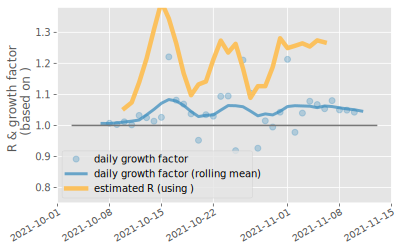

In [4]:
fig, ax = plt.subplots()
ov.plot_reproduction_number(ax=ax, series=cases_jh[-42:])
fig.autofmt_xdate()

Looking at the yellow line, we see an R value of approximately 1.25 since the beginning of November. To extract this number from the reported infections per day, we have assumed reproduction interval of 4 days: i.e. every 4 days each currently infected person will infect 1.25 people. (See https://oscovida.github.io/r-value.html for more details.)

Current infection numbers per day (based on data averaged over the last week) are

In [5]:
daily_cases[-1].astype('int')

36766

If the current exponential growth does not change, we expect the following number of daily infections for the next 4 weeks:


In [6]:
r = 1.25
int = 4  # serial interval (time re-infect next generation)
n0 = float(daily_cases[-1])
days = np.linspace(1, 28, 28)
new_cases = n0*r**(days/4)
index = days.astype('timedelta64[D]') + daily_cases.index[-1]
option1 = pd.DataFrame(index=index, data={'new cases': new_cases, 
                                          'days' : days})
 

Total infections in this data set: 2553504


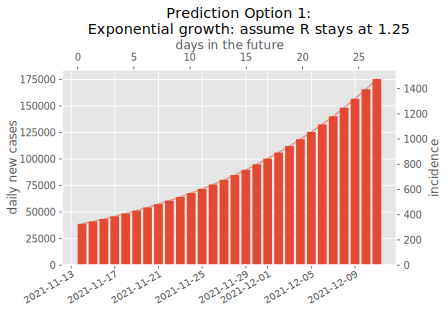

In [7]:
plot_predictions(
    option1['new cases'], 
    "Prediction Option 1:\n Exponential growth: assume R stays at 1.25")

So for ongoing exponential growth, we expect up to 175,000 new infections per day in Germany in 28 days - corresponding to an incidence of 1400. Over 28 days, we look at more than 2.5 million new infections (See discussion below.) 

# Option 2: assume linear growth in daily new infections

'Last data point is from 2021-11-13.'

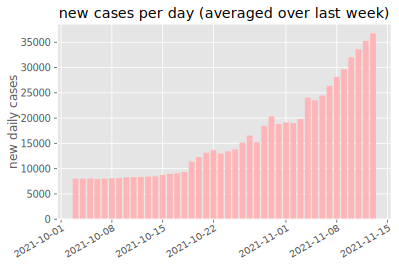

In [8]:
fig, ax = plt.subplots()
ax.bar(daily_cases.index, daily_cases, color='C6')
fig.autofmt_xdate()
ax.set_title("new cases per day (averaged over last week)")
ax.set_ylabel("new daily cases")
f"Last data point is from {daily_cases.index[-1].date()}."

We see somewhat constant daily new infections up to the middle October 2021, then the daily new infections increase significantly. (The incidence is proportional to this.)

### Estimate growth rate of new daily infections by using linear fit for individual weeks

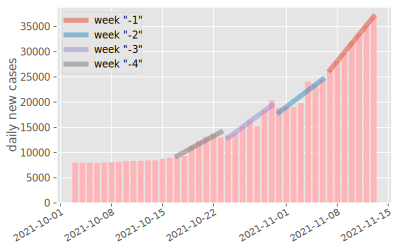

In [9]:
fig, ax = plt.subplots()
ax.bar(daily_cases.index, daily_cases, color='C6', alpha=1)
fit_coef = {}
fit_func = {}
nweeks = 4
for i in range(nweeks):
    # indices for days to look at one week at a time
    start = -7*(i+1)
    stop = -7*i
    if stop == 0: stop = None
    # convert dates to number of days for fitting routine
    X = mdates.date2num(daily_cases.index[start:stop]) 
    Y = daily_cases[start:stop] 
    # fit affine linear function to one week of data points
    ps = np.polyfit(X, Y, 1)
    m, a = ps             # extract slope m and offset a        
    fit_coef[i] = (m, a)  # to display later
    fit = np.poly1d(ps)
    fit_func[i] = fit   # re-use later in the notebook

    ax.plot(Y.index, fit(X), linewidth=5, alpha=0.5, label=f'week "-{i+1}"')

fig.autofmt_xdate()
ax.legend()
ax.set_ylabel("daily new cases");


We can see that the slope of increase tends to increase from week to week. 

In the following, we will use the linear trend shown with the red thick line (for week "-1": that is 1 week in the past) as the **growth model for Option 2**.

The only justification for this choice is that the fit looks good (and that a similar approach worked well for the prediction of new infections in China late 2019/early 2020).

In [10]:
fit_coef

{0: (1766.4693877537343, -33427013.714259814),
 1: (1095.1836734680578, -20714946.816301342),
 2: (1069.4030612242636, -20224457.71938348),
 3: (790.515306122628, -14944854.306125835)}

# Assume number of *daily new infections* stays constant

Based on the last week, we have new infections per day:

In [11]:
# create data frame for convencience
nc1 = []   # new cases
model = fit_func[0]
futuredays = np.arange(1, 30, dtype='int') + mdates.date2num(daily_cases.index[-1])
new_cases = model(futuredays)
incidence = daily_growth_to_incidence(new_cases)
index = pd.to_datetime(mdates.num2date(futuredays)).date
option2 = pd.DataFrame(index=index, data={'new cases' : new_cases,
                                        'incidence' : incidence})

pd.options.display.float_format = '{:,.0f}'.format
option2.iloc[::7, :]

,new cases,incidence
2021-11-14,"38,749",326
2021-11-21,"51,114",430
2021-11-28,"63,479",534
2021-12-05,"75,845",638
2021-12-12,"88,210",743


Total infections in this data set: 1840903


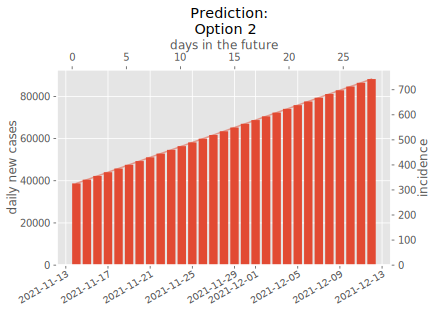

In [12]:
plot_predictions(option2['new cases'], 
                 "Prediction:\n Option 2")

With this assumption, we would see up to 88,000 new infections per day and an incidence of 700. That is a total of 1.8million new infections over 28 days.

# Discussion

### Summary data

Using exponetial growth with R=1.25, we find an incidence up to 1400, up to 175,000 new infections per day, and 2.5million of infections over 28 days.

Using Option2, we find an incidence up to 700, up to 88,000 new infections per day, and 1.8million of infections over 28 days.


### Importance

The number of infections will lead to hospital cases and deaths. For Germany, there were about 5 million infections so far with 100,000 deaths, leading to a rate of about 2% of those infected dying:

In [13]:
print(f"cases      : {cases_jh[-1]}\n"
      f"deaths     : {deaths_jh[-1]}\n"
      f"death rate : {deaths_jh[-1]/cases_jh[-1]*100:.3}%")

cases      : 5037039
deaths     : 97677
death rate : 1.94%


This death rate of 2% is likely to go down now that large parts of the population have been vaccinated, and thus have a much reduced risk of sever illness or death. On the other hand, there is still a very large population of not vaccinated people (1/4 to 1/3 of the population - so still representing a smaller country) which will experience the death rate as before when they get infected.


**We can estimate an order of magnitude of the impact.**

Let's assume a death rate of 0.4% only [1]. In that case, we 

- expect 200 new deaths for every 50,000 new infections 

- the worst case scenario of unlimited exponentional growth suggests 2.5million infections: this would correspond to 2.5m*0.4% = 10,000 new deaths in total.

About half of the patients going to an intensive care unit will eventually die. We can thus estimate the number of intensive care patients as twice that of the deaths (0.7% [1]): 

- With _every day_ of 50,000 new infections, we would expect 50,000*0.7% = 350 _new_ intensive care patients _every day_

- with the exponential growth scenario (Option 1), we expect 0.7% * 2.5million = 17,500 new intensive care patients over the period of 28 days.

[1] Source: [Lothar Wieler, Pressekonferenz zur Corona Lage, 12 November 2021](https://www.youtube.com/watch?v=7gK9YO3LUQI): for 50,000 new infections, expect at least 3000 hospital patients, 350 in need of intensive care, and 200 are expected to die.

## Limits of growth

The assumed growth assumptions are of course a huge simplification. Reasons that may slow down the growth include:

- governements imposing new restrictions
- people changing their behaviour voluntarily

The big question is if and when these (or other factors) come into play to change our path. If there is no change to behaviour, no change to environment conditions, the virus, the accuracy and completeness of the testing, then reality may well follow a path between Option 1 and 2. 

[Austria](https://oscovida.github.io/html/Austria.html) seems to be on a similar trajectory, but is about 3 weeks ahead of Germany. (And has just [decided to have a lock down](https://www.theguardian.com/world/2021/nov/14/austria-orders-lockdown-those-not-fully-vaccinated-against-covid).)